# DepthAI Tutorial: Training a DeepLab V3 + with MobileNet V2 backbone for Semantic Image Segmentation

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI!

This tutorial will include comments near code for easier understanding and will cover:
* Downloading the DeeplabV3+ model from [tensorflow/models](https://github.com/tensorflow/models),
* Setting up the PASCAL VOC 2012 dataset,
* Initialization of the model with a pretrained version,
* Training, evaluation, and visualization,
* Converting the model to OpenVINO intermediate representation,
* Information about additional steps.

This model can run on our DepthAI Myriad X modules.
You can make a copy of this tutorial: File -> Save a copy in Drive

Note: you can train on your own images if you replace the PASCAL dataset with your own dataset that follows the PASCAL format.

In [12]:
!pip install tensorflow==1.15


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Fetched 6,555 B in 1s (7,090 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... D

Install *tf_slim* and download the Deeplab code from [tensorflow/models](https://github.com/tensorflow/models). Note that we only download the code needed for this tutorial and do not clone the whole repository.

In [ ]:
!pip install tf_slim==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 23.6 MB/s 


In [ ]:
! apt install subversion
! svn checkout https://github.com/tensorflow/models/trunk/research/deeplab
! svn checkout https://github.com/tensorflow/models/trunk/research/slim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,235 kB of archives.
After this operation, 9,916 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/unive

In [ ]:
%cd deeplab/datasets

/content/deeplab/datasets


Download PASCAL VOC 2012 Dataset and convert it to TFRecord with the script provided in datasets directory of the Deeplab.

In [ ]:
! bash download_and_convert_voc2012.sh
%cd /content/deeplab/

Set up paths to directories, where:
* **init_models** will containt initial weights/pretrained model,
* **train** will contain model checkpoints and logs,
* **eval** will contain evaluation logs,
* **vis** will contain visualization results, and
* **export** will contain a frozen model.

In [ ]:
DATASETS="datasets"
PASCAL_FOLDER="pascal_voc_seg"
EXP_FOLDER="exp/train_on_train_set_mobilenetv2"
! mkdir -p $DATASETS/$PASCAL_FOLDER/init_models
! mkdir -p $DATASETS/$PASCAL_FOLDER/$EXP_FOLDER/train
! mkdir -p $DATASETS/$PASCAL_FOLDER/$EXP_FOLDER/eval
! mkdir -p $DATASETS/$PASCAL_FOLDER/$EXP_FOLDER/vis
! mkdir -p $DATASETS/$PASCAL_FOLDER/$EXP_FOLDER/export

Download the pretrained *deeplabv3_mnv2* on PASCAL dataset from tensorflow.org.

In [ ]:
PRETRAINED_MODEL = "deeplabv3_mnv2_pascal_train_aug"
PRETRAINED_VERSION = "_2018_01_29.tar.gz"
%cd $DATASETS/$PASCAL_FOLDER/init_models
! wget -nd -c http://download.tensorflow.org/models/$PRETRAINED_MODEL$PRETRAINED_VERSION
! tar -xf $PRETRAINED_MODEL$PRETRAINED_VERSION
%cd /content/deeplab

/content/deeplab/datasets/pascal_voc_seg/init_models
--2022-08-22 19:01:31--  http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.31.128, 2607:f8b0:4004:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.31.128|:80... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.

/content/deeplab


## Testing

Add need paths to the PYTHONPATH and execute *model_test.py* that is provided with the Deeplab, to check if it is set up correctly.

In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/:/content/slim/"
! python model_test.py


Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] DeeplabModelTest.testBuildDeepLabWithDensePredictionCell
Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
W0822 19:01:40.928075 139868108683136 deprecation.py:323] From /usr/lib/python3.7/contextlib.py:82: TensorFlowTestCase.test_session (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
2022-08-22 19:01:40.928373: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-22 19:01:40.957693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 19:01:40.958506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties:

## Training

In addition to setting up paths to directories with initial checkpoints, log outputs, and dataset, you can set up some other parameters.

* **NUM_ITERATIONS** represents a number of training steps. Use a higher number of iterations (e.g., 1000+). We use only 10 for the example.
* **CROP_SIZE**, the crop size and input size of the model.
  * crop size should be a multiple of **OUTPUT_STRIDE**.
* **BATCH_SIZE** can be higher than 8, 12, 16 or even more, if it fits on the GPU.

In the second cell you can also change the backbone with *model_variant*, but you have to download different pretrained model in the upper cells. With *train_split* you can also choose on which images to train the model (e.g., available option is also "*trainval*").

You can also change *fine_tune_batch_norm* to *False* for faster training, but worse performance.

In [ ]:
OUTPUT_STRIDE = 8
BATCH_SIZE = 8
CROP_SIZE = 256
NUM_ITERATIONS = 10
INIT_CKPT = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/init_models/{PRETRAINED_MODEL}/model.ckpt-30000"
LOG_DIR_TRAIN = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/{EXP_FOLDER}/train"
DATASET_PATH = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/tfrecord"
CROP_SIZE_TXT = f"{CROP_SIZE+1},{CROP_SIZE+1}"

In [ ]:
! python train.py \
--logtostderr \
--train_split="train" \
--model_variant="mobilenet_v2" \
--output_stride=$OUTPUT_STRIDE \
--train_crop_size=$CROP_SIZE_TXT \
--train_batch_size=$BATCH_SIZE \
--training_number_of_steps=$NUM_ITERATIONS \
--fine_tune_batch_norm=true \
--tf_initial_checkpoint=$INIT_CKPT \
--train_logdir=$LOG_DIR_TRAIN \
--dataset_dir=$DATASET_PATH


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0822 19:02:26.825023 139813627848576 module_wrapper.py:139] From train.py:274: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0822 19:02:26.825206 139813627848576 module_wrapper.py:139] From train.py:274: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0822 19:02:26.825397 139813627848576 module_wrapper.py:139] From train.py:289: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0822 19:02:26.825564 139813627848576 module_wrapper.py:139] From train.py:290: The name tf.logging.info is deprec

## Eval

Here we run the evaluation script provided with the Deeplab. Note that *eval_crop_size* should be larger than the size of the largest image in the validation set.

In [ ]:
LOG_DIR_EVAL = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/{EXP_FOLDER}/eval"

In [ ]:
! python eval.py \
--logtostderr \
--eval_split="val" \
--model_variant="mobilenet_v2" \
--eval_crop_size="513,513" \
--checkpoint_dir=$LOG_DIR_TRAIN \
--eval_logdir=$LOG_DIR_EVAL \
--dataset_dir=$DATASET_PATH \
--max_number_of_evaluations=1

## Visualization

Here we run the visualization script provided with the Deeplab. Note that *eval_crop_size* should be larger than the size of the largest image in the validation set.

In [ ]:
LOG_DIR_VIS = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/{EXP_FOLDER}/vis"

In [ ]:
! python vis.py \
--logtostderr \
--vis_split="val" \
--model_variant="mobilenet_v2" \
--vis_crop_size="513,513" \
--checkpoint_dir=$LOG_DIR_TRAIN \
--vis_logdir=$LOG_DIR_VIS \
--dataset_dir=$DATASET_PATH \
--max_number_of_iterations=1

You can find segmentation results in the previously created *vis* directory. Here is an example of input image and the output:


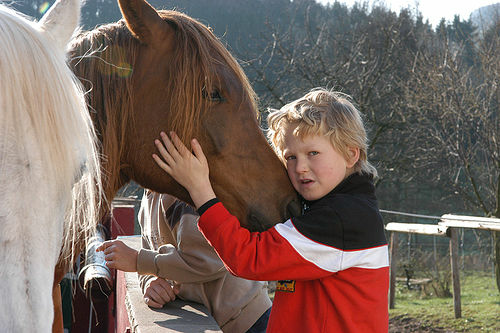
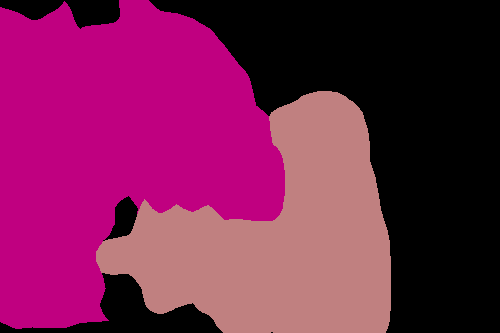

## Exporing the trained checkpoint

With the provided *export_model.py* we freeze and export the model. Note that *num_classes* depends on the dataset. PASCAL VOC 2012 has total 21 classes (20 + 1 background).

In [ ]:
CKPT_PATH=f"{LOG_DIR_TRAIN}/model.ckpt-{NUM_ITERATIONS}"
EXPORT_PATH = f"/content/deeplab/{DATASETS}/{PASCAL_FOLDER}/{EXP_FOLDER}/export/frozen_inference_graph.pb"

In [ ]:
! python export_model.py \
--logtostderr \
--checkpoint_path=$CKPT_PATH \
--export_path=$EXPORT_PATH \
--model_variant="mobilenet_v2" \
--num_classes=21 \
--crop_size=$CROP_SIZE \
--crop_size=$CROP_SIZE \
--inference_scales=1.0


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0822 19:09:28.339929 140235069065088 module_wrapper.py:139] From export_model.py:117: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0822 19:09:28.340116 140235069065088 module_wrapper.py:139] From export_model.py:117: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0822 19:09:28.340266 140235069065088 module_wrapper.py:139] From export_model.py:118: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Prepare to export model to: /content/deeplab/datasets/pascal_voc_seg/exp/tr

# OpenVINO

In this section we will istall OpenVINO 2021.4 and convert the frozen model to *.bin* and *.xml*.

In [ ]:
%cd /content/

/content


In [ ]:
%%time
%%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
#! wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16612/l_openvino_toolkit_p_2020.2.120.tgz
! wget https://github.com/PINTO0309/tflite2tensorflow/releases/download/v1.10.4/l_openvino_toolkit_p_2021.4.582.tgz
path = "l_openvino_toolkit_p_2021.4.582.tgz"

## install openvino
!tar xf "{path}"
%cd l_openvino_toolkit_p_2021.4.582/

!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

CPU times: user 681 ms, sys: 101 ms, total: 782 ms
Wall time: 1min 48s


In [ ]:
!bash /opt/intel/openvino_2021/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

Convert the frozen TF model to OpenVINO Intermediate Representation: .xml and .bin. As input shape choose the crop size used above in export.py , e.g. 256.

In [ ]:
!source /opt/intel/openvino_2021/bin/setupvars.sh
! python /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py \
--input_model  /content/deeplab/datasets/pascal_voc_seg/exp/train_on_train_set_mobilenetv2/export/frozen_inference_graph.pb \
--model_name deeplab_v3_plus_mnv2_decoder_256 \
--data_type FP16 \
--input_shape [1,$CROP_SIZE,$CROP_SIZE,3] \
--reverse_input_channel \
--output_dir /content/


[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/deeplab/datasets/pascal_voc_seg/exp/train_on_train_set_mobilenetv2/export/frozen_inference_graph.pb
	- Path for generated IR: 	/content/
	- IR output name: 	deeplab_v3_plus_mnv2_decoder_256
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,256,256,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers imp

In [ ]:
%cd /content/

/content


### Fixing XML - Very important step!

At this point, since OpenVINO version 2020.3, the obtained *.xml* is broken and will not let you directly create a *.blob*. To fix this, we need to change the following code located in *.xml*:

```
<layer id="490" name="strided_slice_10/extend_end_const1245431561" type="Const" version="opset1">
	<data element_type="i64" offset="924018" shape="1" size="8"/>
	<output>
		<port id="0" precision="I64">
			<dim>1</dim>
		</port>
	</output>
</layer>
```

We need to **change element_type to i32** instead of **i64**. The edited line should look like this:
```
<data element_type="i32" offset="924018" shape="1" size="8"/>
```

We do this by executing the following code.

In [ ]:
import xml.etree.ElementTree as ET

tree = ET.parse("/content/deeplab_v3_plus_mnv2_decoder_256.xml")
root = tree.getroot()
data = root.find('.//layer[@name="strided_slice_10/extend_end_const1245431561"]/data')
data.set("element_type", "i32")

tree.write("/content/deeplab_v3_plus_mnv2_decoder_256.xml")


Download obtained *.bin* and *.xml* and use http://blobconverter.luxonis.com/ to convert them to *.blob*. Choose **2021.4** and **OpenVINO**. Upload *.bin* and *.xml*. Suggested number of shaves is 6.

Alternatively, if you are not using Colab, you can just execute the following code:
If you are using Colab, this will not work, as you have to download the *.xml* to edit the element_type.


In [ ]:
# Choose the directory where you would like to save the blob.
blob_dir = "/content"

binfile = "/content/deeplab_v3_plus_mnv2_decoder_256.bin"
xmlfile = "/content/deeplab_v3_plus_mnv2_decoder_256.xml"

!python -m pip install blobconverter

import blobconverter
blob_path = blobconverter.from_openvino(
    xml=xmlfile,
    bin=binfile,
    data_type="FP16",
    shaves=6,
    version="2021.4"
)
from google.colab import files
files.download(blob_path)

[==================================================]
Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After obtaining the *.blob* you can try it out by cloning [this](https://github.com/luxonis/depthai-experiments/tree/master/gen2-deeplabv3_multiclass) directory from [luxonis/depthai-experiments](https://github.com/luxonis/depthai-experiments/tree/master/gen2-deeplabv3_multiclass). Just put your *.blob* into the *models* directory and specify its path when running the script. See README in the directory for more information on running the script.